In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/financial-dataset-for-fraud-detection-in-a-comapny/Fraud.csv


# **FRAUD DETECTION**

**Fraud detection is the process of identifying and preventing fraudulent activities or behaviors within a system or organization. It involves using various techniques, technologies, and methodologies to detect, investigate, and mitigate fraudulent actions, such as unauthorized access, theft, deception, or misuse of resources.**

Data for the case is available in CSV format having 6362620 rows and 10 columns

**Data Dictionary**

step - maps a unit of time in the real world. In this case 1 step is 1 hour of time. Total steps 744 (30 days simulation).

type - CASH-IN, CASH-OUT, DEBIT, PAYMENT and TRANSFER.

amount - amount of the transaction in local currency.

nameOrig - customer who started the transaction

oldbalanceOrg - initial balance before the transaction

newbalanceOrig - new balance after the transaction

nameDest - customer who is the recipient of the transaction

oldbalanceDest - initial balance recipient before the transaction. Note that there is not information for customers that start with M (Merchants).

newbalanceDest - new balance recipient after the transaction. Note that there is not information for customers that start with M (Merchants).

isFraud - This is the transactions made by the fraudulent agents inside the simulation. In this specific dataset the fraudulent behavior of the agents aims to profit by taking control or customers accounts and try to empty the funds by transferring to another account and then cashing out of the system.

isFlaggedFraud - The business model aims to control massive transfers from one account to another and flags illegal attempts. An illegal attempt in this dataset is an attempt to transfer more than 200.000 in a single transaction.

**In this project, we are using Random Forest Regressor along with Down-Sampling as well as Over-Sampling techniques to preprocess the dataset and train the model**

### Import Libraries

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
from ydata_profiling import ProfileReport
from sklearn.metrics import classification_report,accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

# DATA COLLECTION

In [3]:
df = pd.read_csv('/kaggle/input/financial-dataset-for-fraud-detection-in-a-comapny/Fraud.csv')
df.head()

step      type    amount     nameOrig  oldbalanceOrg  newbalanceOrig  \
0     1   PAYMENT   9839.64  C1231006815       170136.0       160296.36   
1     1   PAYMENT   1864.28  C1666544295        21249.0        19384.72   
2     1  TRANSFER    181.00  C1305486145          181.0            0.00   
3     1  CASH_OUT    181.00   C840083671          181.0            0.00   
4     1   PAYMENT  11668.14  C2048537720        41554.0        29885.86   

      nameDest  oldbalanceDest  newbalanceDest  isFraud  isFlaggedFraud  
0  M1979787155             0.0             0.0        0               0  
1  M2044282225             0.0             0.0        0               0  
2   C553264065             0.0             0.0        1               0  
3    C38997010         21182.0             0.0        1               0  
4  M1230701703             0.0             0.0        0               0

# Explore Data

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 11 columns):
 #   Column          Dtype  
---  ------          -----  
 0   step            int64  
 1   type            object 
 2   amount          float64
 3   nameOrig        object 
 4   oldbalanceOrg   float64
 5   newbalanceOrig  float64
 6   nameDest        object 
 7   oldbalanceDest  float64
 8   newbalanceDest  float64
 9   isFraud         int64  
 10  isFlaggedFraud  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 534.0+ MB


Our Dataset contains 10 features,
* step
* type
* amount
* nameOrig
* oldbalanceOrg
* newbalanceOrig
* nameDest
* oldbalanceDest
* newbalanceDest
* isFraud
* isFlaggedFraud
having a total of 6362620 entries

In [5]:
df.describe()

step        amount  oldbalanceOrg  newbalanceOrig  \
count  6.362620e+06  6.362620e+06   6.362620e+06    6.362620e+06   
mean   2.433972e+02  1.798619e+05   8.338831e+05    8.551137e+05   
std    1.423320e+02  6.038582e+05   2.888243e+06    2.924049e+06   
min    1.000000e+00  0.000000e+00   0.000000e+00    0.000000e+00   
25%    1.560000e+02  1.338957e+04   0.000000e+00    0.000000e+00   
50%    2.390000e+02  7.487194e+04   1.420800e+04    0.000000e+00   
75%    3.350000e+02  2.087215e+05   1.073152e+05    1.442584e+05   
max    7.430000e+02  9.244552e+07   5.958504e+07    4.958504e+07   

       oldbalanceDest  newbalanceDest       isFraud  isFlaggedFraud  
count    6.362620e+06    6.362620e+06  6.362620e+06    6.362620e+06  
mean     1.100702e+06    1.224996e+06  1.290820e-03    2.514687e-06  
std      3.399180e+06    3.674129e+06  3.590480e-02    1.585775e-03  
min      0.000000e+00    0.000000e+00  0.000000e+00    0.000000e+00  
25%      0.000000e+00    0.000000e+00  0.000000e+00    0.000000e+00  
50%      1.327057e+05    2.146614e+05  0.000000e+00    0.000000e+00  
75%      9.430367e+05    1.111909e+06  0.000000e+00    0.000000e+00  
max      3.560159e+08    3.561793e+08  1.000000e+00    1.000000e+00

In [6]:
df.describe(include='O').T

count   unique          top     freq
type      6362620        5     CASH_OUT  2237500
nameOrig  6362620  6353307  C1902386530        3
nameDest  6362620  2722362  C1286084959      113

There are only 3 object data type columns
* type
* nameOrig
* nameDest

with only 5 unique type of transactions

In [7]:
df.type.unique()

array(['PAYMENT', 'TRANSFER', 'CASH_OUT', 'DEBIT', 'CASH_IN'],
      dtype=object)

In [8]:
df.step.unique()

array([  1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,
        14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,
        27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,
        40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,
        53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,  65,
        66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,  78,
        79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,  91,
        92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103, 104,
       105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117,
       118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130,
       131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143,
       144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156,
       157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169,
       170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 18

In [9]:
df.isFraud.unique()

array([0, 1])

In [10]:
df.isFlaggedFraud.unique()

array([0, 1])

In [11]:
# Dataframe containing fraud transactions
df[df['isFraud'] == 1].head()

step      type   amount     nameOrig  oldbalanceOrg  newbalanceOrig  \
2       1  TRANSFER    181.0  C1305486145          181.0             0.0   
3       1  CASH_OUT    181.0   C840083671          181.0             0.0   
251     1  TRANSFER   2806.0  C1420196421         2806.0             0.0   
252     1  CASH_OUT   2806.0  C2101527076         2806.0             0.0   
680     1  TRANSFER  20128.0   C137533655        20128.0             0.0   

        nameDest  oldbalanceDest  newbalanceDest  isFraud  isFlaggedFraud  
2     C553264065             0.0             0.0        1               0  
3      C38997010         21182.0             0.0        1               0  
251   C972765878             0.0             0.0        1               0  
252  C1007251739         26202.0             0.0        1               0  
680  C1848415041             0.0             0.0        1               0

In [12]:
df[df['isFraud'] == 1].info()

<class 'pandas.core.frame.DataFrame'>
Index: 8213 entries, 2 to 6362619
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   step            8213 non-null   int64  
 1   type            8213 non-null   object 
 2   amount          8213 non-null   float64
 3   nameOrig        8213 non-null   object 
 4   oldbalanceOrg   8213 non-null   float64
 5   newbalanceOrig  8213 non-null   float64
 6   nameDest        8213 non-null   object 
 7   oldbalanceDest  8213 non-null   float64
 8   newbalanceDest  8213 non-null   float64
 9   isFraud         8213 non-null   int64  
 10  isFlaggedFraud  8213 non-null   int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 770.0+ KB


As can be observed, there are about 8312 fraudulent transactions out of the total of 6362620 transactions

In [13]:
df.isnull().sum()

step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
isFlaggedFraud    0
dtype: int64

There are no missing values in the dataset. 

#### Report Generation

In [14]:
pr = ProfileReport(df = df, title = 'Pandas Profile Report', explorative = True)
pr

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

From the above report, we can infer that
* amount is highly overall correlated with newbalanceDest
* newbalanceOrig is highly overall correlated with oldbalanceOrg
* oldbalanceDest is highly overall correlated with amount
* isFraud is highly imbalanced (98.6%)
* isFlaggedFraud is highly imbalanced (>99.9%)

Due to high imabalnce, we might need to resample 'isFraud' and 'isFlaggedFraud' later, using either Downsampling or Sampling techniques 

<Axes: xlabel='isFraud', ylabel='count'>

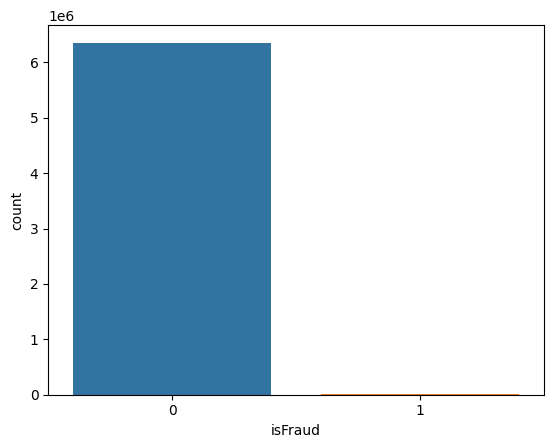

In [15]:
sns.countplot(x = 'isFraud', data = df)

Fraud Transactions are a minority as compared to Normal Transactions

In [16]:
df['type'].value_counts()

type
CASH_OUT    2237500
PAYMENT     2151495
CASH_IN     1399284
TRANSFER     532909
DEBIT         41432
Name: count, dtype: int64

<Axes: xlabel='type', ylabel='count'>

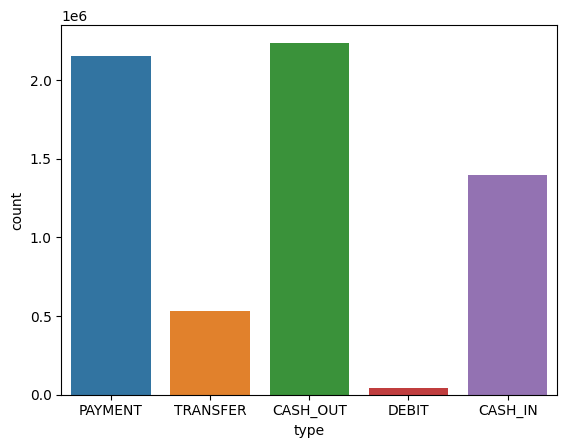

In [17]:
sns.countplot(x = 'type', data = df)

It can be observed that Cash Out and Payment are the majority of the Transaction types, while Debit is the least type of transaction

In [18]:
df['amount'].info()

<class 'pandas.core.series.Series'>
RangeIndex: 6362620 entries, 0 to 6362619
Series name: amount
Non-Null Count    Dtype  
--------------    -----  
6362620 non-null  float64
dtypes: float64(1)
memory usage: 48.5 MB


In [19]:
df['amount'].describe()

count    6.362620e+06
mean     1.798619e+05
std      6.038582e+05
min      0.000000e+00
25%      1.338957e+04
50%      7.487194e+04
75%      2.087215e+05
max      9.244552e+07
Name: amount, dtype: float64

In [14]:
from sklearn.feature_selection import mutual_info_classif

In [15]:
def make_mi_scores(X, y):
    X = X.copy()
    for colname in X.select_dtypes(["object", "category"]):
        X[colname], _ = X[colname].factorize()
    # All discrete features should now have integer dtypes
    discrete_features = [pd.api.types.is_integer_dtype(t) for t in X.dtypes]
    mi_scores = mutual_info_classif(X, y, discrete_features=discrete_features, random_state=0)
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    return mi_scores

In [16]:
def plot_mi_scores(scores):
    scores = scores.sort_values(ascending=True)
    width = np.arange(len(scores))
    ticks = list(scores.index)
    plt.barh(width, scores)
    plt.yticks(width, ticks)
    plt.title("Mutual Information Scores")

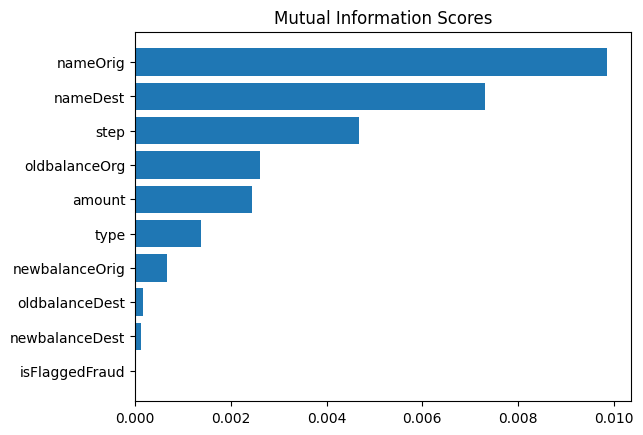

In [23]:
X_temp = df.copy()
y_temp = X_temp.pop('isFraud')
mi_scores = make_mi_scores(X_temp, y_temp)

plot_mi_scores(mi_scores)

As we can see the amount feature tells the most about the transaction being fraudulent or not while the mutual score of isFlaggedFraud is 0, hence, it might be better to just drop that feature

In [17]:
df.drop(['isFlaggedFraud'], axis = 1, inplace = True)

In [20]:
fraud = df[df['isFraud'] == 1]
notfraud = df[df['isFraud'] == 0]

In [21]:
fraud.head() # Dataframe of Fraud Transactions

step      type   amount     nameOrig  oldbalanceOrg  newbalanceOrig  \
2       1  TRANSFER    181.0  C1305486145          181.0             0.0   
3       1  CASH_OUT    181.0   C840083671          181.0             0.0   
251     1  TRANSFER   2806.0  C1420196421         2806.0             0.0   
252     1  CASH_OUT   2806.0  C2101527076         2806.0             0.0   
680     1  TRANSFER  20128.0   C137533655        20128.0             0.0   

        nameDest  oldbalanceDest  newbalanceDest  isFraud  
2     C553264065             0.0             0.0        1  
3      C38997010         21182.0             0.0        1  
251   C972765878             0.0             0.0        1  
252  C1007251739         26202.0             0.0        1  
680  C1848415041             0.0             0.0        1

In [22]:
notfraud.head() # Dataframe containing normal transactions

step     type    amount     nameOrig  oldbalanceOrg  newbalanceOrig  \
0     1  PAYMENT   9839.64  C1231006815       170136.0       160296.36   
1     1  PAYMENT   1864.28  C1666544295        21249.0        19384.72   
4     1  PAYMENT  11668.14  C2048537720        41554.0        29885.86   
5     1  PAYMENT   7817.71    C90045638        53860.0        46042.29   
6     1  PAYMENT   7107.77   C154988899       183195.0       176087.23   

      nameDest  oldbalanceDest  newbalanceDest  isFraud  
0  M1979787155             0.0             0.0        0  
1  M2044282225             0.0             0.0        0  
4  M1230701703             0.0             0.0        0  
5   M573487274             0.0             0.0        0  
6   M408069119             0.0             0.0        0

In [23]:
max_fraud_amount = fraud['amount'].max()
max_fraud_amount

10000000.0

In [24]:
max_normal_amount = notfraud['amount'].max()
max_normal_amount

92445516.64

<Axes: xlabel='type', ylabel='count'>

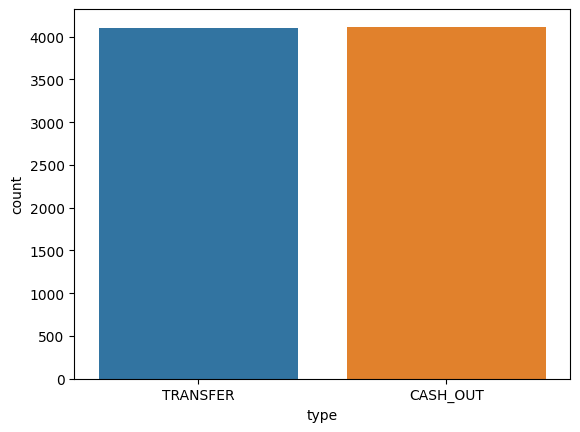

In [25]:
sns.countplot(x='type', data = fraud)

In [26]:
dic_ = {}
for i in fraud['amount']:
    if i not in dic_:
        dic_[i] = 1
    else:
        dic_[i] += 1

In [27]:
%%capture
dic_

In [28]:
max_key = None
max_value = None

for key, value in dic_.items():
    if max_value is None or value > max_value:
        max_key = key
        max_value = value
print("Amount corresponding to Maximum number of Transaction :", max_key)
print("Count of Maximum number of Transction to a particular Amount", max_value)

Amount corresponding to Maximum number of Transaction : 10000000.0
Count of Maximum number of Transction to a particular Amount 287


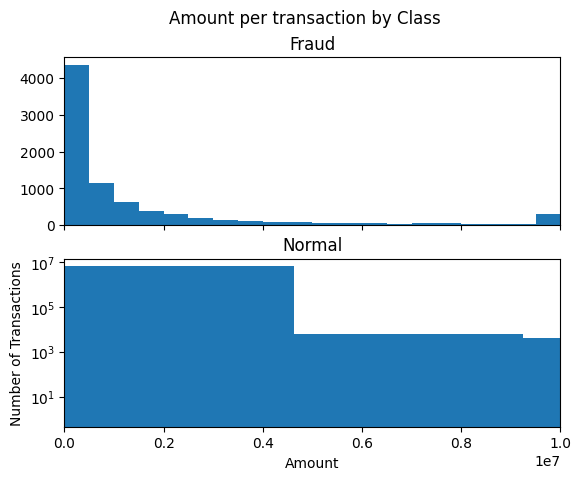

In [29]:
f, (ax1, ax2) = plt.subplots(2, 1, sharex = True)
f.suptitle('Amount per transaction by Class')
bins = 20
ax1.hist(fraud.amount, bins = bins)
ax1.set_title('Fraud')
ax2.hist(notfraud.amount, bins = bins)
ax2.set_title('Normal')
plt.xlabel('Amount')
plt.ylabel('Number of Transactions')
plt.xlim((0,10000000))
plt.yscale('log')
plt.show()

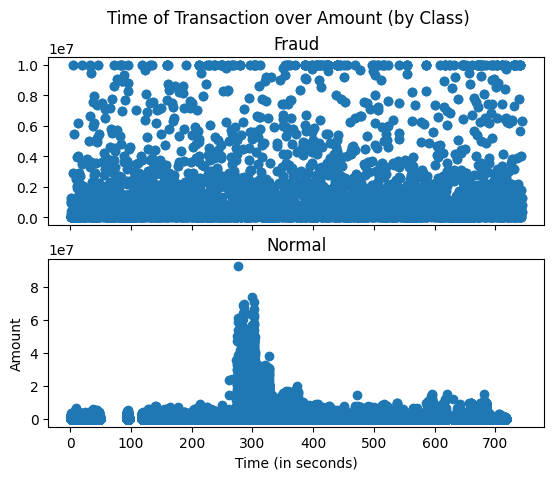

In [30]:
f, (ax1, ax2) = plt.subplots(2,1,sharex=True)
f.suptitle('Time of Transaction over Amount (by Class)')
ax1.scatter(fraud.step, fraud.amount)
ax1.set_title('Fraud')
ax2.scatter(notfraud.step, notfraud.amount)
ax2.set_title('Normal')
plt.xlabel('Time (in seconds)')
plt.ylabel('Amount')
plt.show()

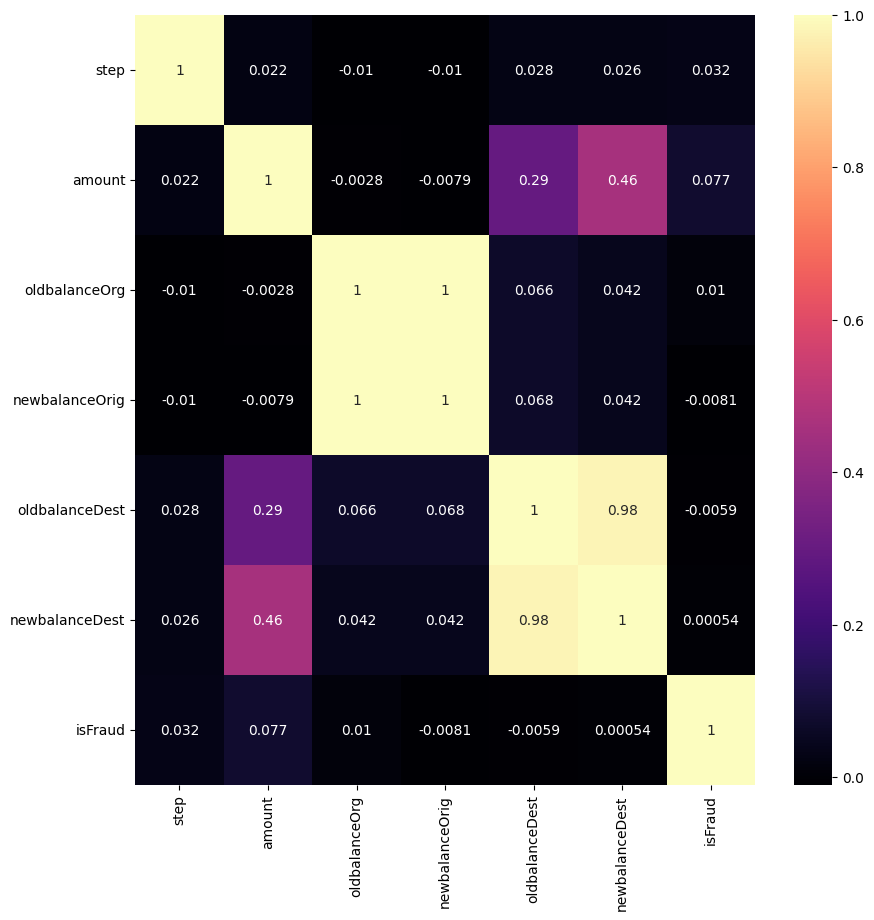

In [43]:
#get correlations of each features in dataset
corrmat = df.corr(numeric_only=True)
top_corr_features = corrmat.index
plt.figure(figsize=(10,10))
#plot heat map
g=sns.heatmap(df[top_corr_features].corr(),annot=True,cmap="magma")

As analyzed from the report, amount, oldbalanceDest, newbalanceDest, oldbalanceOrg and newbalanceOrig are highly correlated

In [31]:
# Handle multi-collinearity
corr = df.corr(numeric_only = True)
print(corr)
high_corr_cols = corr.where(np.triu(np.ones(corr.shape), k=1).astype(np.bool_)).abs()
to_drop = [column for column in high_corr_cols.columns if any(high_corr_cols[column] > 0.8)]
df1 = df.drop(to_drop, axis=1)

                    step    amount  oldbalanceOrg  newbalanceOrig  \
step            1.000000  0.022373      -0.010058       -0.010299   
amount          0.022373  1.000000      -0.002762       -0.007861   
oldbalanceOrg  -0.010058 -0.002762       1.000000        0.998803   
newbalanceOrig -0.010299 -0.007861       0.998803        1.000000   
oldbalanceDest  0.027665  0.294137       0.066243        0.067812   
newbalanceDest  0.025888  0.459304       0.042029        0.041837   
isFraud         0.031578  0.076688       0.010154       -0.008148   

                oldbalanceDest  newbalanceDest   isFraud  
step                  0.027665        0.025888  0.031578  
amount                0.294137        0.459304  0.076688  
oldbalanceOrg         0.066243        0.042029  0.010154  
newbalanceOrig        0.067812        0.041837 -0.008148  
oldbalanceDest        1.000000        0.976569 -0.005885  
newbalanceDest        0.976569        1.000000  0.000535  
isFraud              -0.005885    

In [32]:
outlier_fraction = len(fraud)/float(len(notfraud))
outlier_fraction

0.0012924888191769902

In [33]:
df_new = df.copy()
df_new = pd.get_dummies(df_new, columns=["type"])
df_new.drop("nameOrig" ,axis=1 , inplace = True)
df_new.drop("nameDest" ,axis=1 , inplace = True)

In [34]:
df_new.head()

step    amount  oldbalanceOrg  newbalanceOrig  oldbalanceDest  \
0     1   9839.64       170136.0       160296.36             0.0   
1     1   1864.28        21249.0        19384.72             0.0   
2     1    181.00          181.0            0.00             0.0   
3     1    181.00          181.0            0.00         21182.0   
4     1  11668.14        41554.0        29885.86             0.0   

   newbalanceDest  isFraud  type_CASH_IN  type_CASH_OUT  type_DEBIT  \
0             0.0        0         False          False       False   
1             0.0        0         False          False       False   
2             0.0        1         False          False       False   
3             0.0        1         False           True       False   
4             0.0        0         False          False       False   

   type_PAYMENT  type_TRANSFER  
0          True          False  
1          True          False  
2         False           True  
3         False          False  
4          True          False

## Resampling of Dataset

In [35]:
from sklearn.utils import resample

### Up-Sampling

In [36]:
majority = df_new[(df_new['isFraud'] == 0)]
minority = df_new[(df_new['isFraud'] == 1)]

minority_oversampled = resample( minority, replace = True, n_samples = 6354407, random_state = 42)

df_oversampled = pd.concat([minority_oversampled, majority])
df_oversampled.isFraud.value_counts()

isFraud
1    6354407
0    6354407
Name: count, dtype: int64

In [37]:
X_oversampled = df_oversampled.drop('isFraud', axis=1)
y_oversampled = df_oversampled['isFraud']
X_oversampled.shape, y_oversampled.shape

((12708814, 11), (12708814,))

In [38]:
y = df["isFraud"]

In [39]:
X = df_new.drop("isFraud", axis=1)

In [40]:
X

step      amount  oldbalanceOrg  newbalanceOrig  oldbalanceDest  \
0           1     9839.64      170136.00       160296.36            0.00   
1           1     1864.28       21249.00        19384.72            0.00   
2           1      181.00         181.00            0.00            0.00   
3           1      181.00         181.00            0.00        21182.00   
4           1    11668.14       41554.00        29885.86            0.00   
...       ...         ...            ...             ...             ...   
6362615   743   339682.13      339682.13            0.00            0.00   
6362616   743  6311409.28     6311409.28            0.00            0.00   
6362617   743  6311409.28     6311409.28            0.00        68488.84   
6362618   743   850002.52      850002.52            0.00            0.00   
6362619   743   850002.52      850002.52            0.00      6510099.11   

         newbalanceDest  type_CASH_IN  type_CASH_OUT  type_DEBIT  \
0                  0.00         False          False       False   
1                  0.00         False          False       False   
2                  0.00         False          False       False   
3                  0.00         False           True       False   
4                  0.00         False          False       False   
...                 ...           ...            ...         ...   
6362615       339682.13         False           True       False   
6362616            0.00         False          False       False   
6362617      6379898.11         False           True       False   
6362618            0.00         False          False       False   
6362619      7360101.63         False           True       False   

         type_PAYMENT  type_TRANSFER  
0                True          False  
1                True          False  
2               False           True  
3               False          False  
4                True          False  
...               ...            ...  
6362615         False          False  
6362616         False           True  
6362617         False          False  
6362618         False           True  
6362619         False          False  

[6362620 rows x 11 columns]

### Down-Sampling

In [41]:
from imblearn.under_sampling import RandomUnderSampler
from collections import Counter

In [42]:
rus = RandomUnderSampler(random_state=42)

X_undersampled, y_undersampled = rus.fit_resample(X, y)
print(f"The number of Classes before the fit {Counter(y)}")
print(f"The number of Classes after the fit {Counter(y_undersampled)}")

The number of Classes before the fit Counter({0: 6354407, 1: 8213})
The number of Classes after the fit Counter({0: 8213, 1: 8213})


In [43]:
X_undersampled.head()

step     amount  oldbalanceOrg  newbalanceOrig  oldbalanceDest  \
1777056   162  183806.32       19391.00            0.00       382572.19   
1350600   137     521.37           0.00            0.00            0.00   
1991933   179    3478.18       19853.00        16374.82            0.00   
5092368   355    1716.05        5769.17         4053.13            0.00   
5066515   354  253129.93     1328499.49      1581629.42      2713220.48   

         newbalanceDest  type_CASH_IN  type_CASH_OUT  type_DEBIT  \
1777056       566378.51         False           True       False   
1350600            0.00         False          False       False   
1991933            0.00         False          False       False   
5092368            0.00         False          False       False   
5066515      2460090.55          True          False       False   

         type_PAYMENT  type_TRANSFER  
1777056         False          False  
1350600          True          False  
1991933          True          False  
5092368          True          False  
5066515         False          False

In [44]:
df_melted = X_undersampled.melt(id_vars=['amount'], 
                    value_vars=['type_CASH_IN', 'type_CASH_OUT', 'type_DEBIT', 'type_PAYMENT', 'type_TRANSFER'], 
                    var_name='type', value_name='value')

# Filter out rows where the value is False
df_melted = df_melted[df_melted['value']]

# Drop the 'value' column as it's no longer needed
df_melted = df_melted.drop(columns='value')

In [45]:
df_melted['label'] = np.repeat(y_undersampled, len(df_melted) // len(y_undersampled))

/tmp/ipykernel_33/482594528.py:1: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-darkgrid')
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


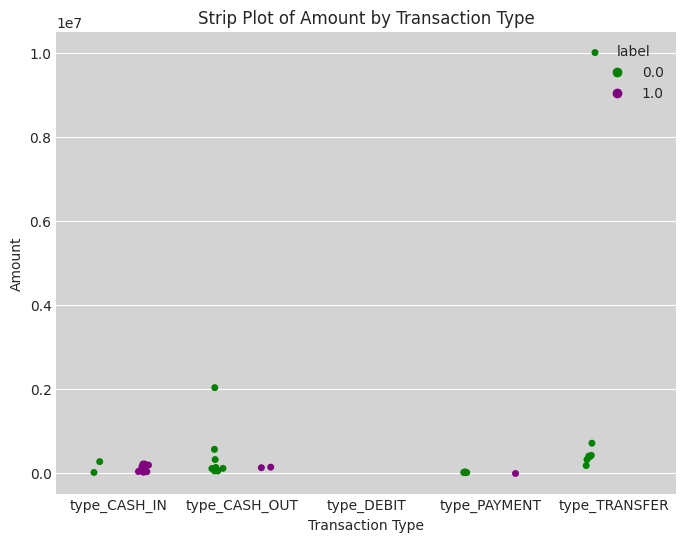

In [46]:
plt.style.use('seaborn-darkgrid')
custom_palette = {0: 'green', 1: 'purple'}

# Create the strip plot with a grey background and custom scatter point colors
plt.figure(figsize=(8, 6))
ax = sns.stripplot(x='type', y='amount', hue='label', data=df_melted, dodge=True, jitter=True, palette=custom_palette)
ax.set_facecolor('lightgrey')  # Set background color to grey
plt.title('Strip Plot of Amount by Transaction Type')
plt.xlabel('Transaction Type')
plt.ylabel('Amount')
plt.show()

Here we can again see the types of transactions used for fraud as we've seen in the graph above but we can also see the amount of a transaction in regards to the type of the transaction. We already knew that Cash transactions were the types that were used in fraud but we can also see that because those are the ones used for fraud that they are also the types that include the highest money amount. Also, it is surprising to see that Transfer Transaction does not have any fraud

In [47]:
df_undersampled = pd.concat([X_undersampled, y_undersampled], axis = 1)

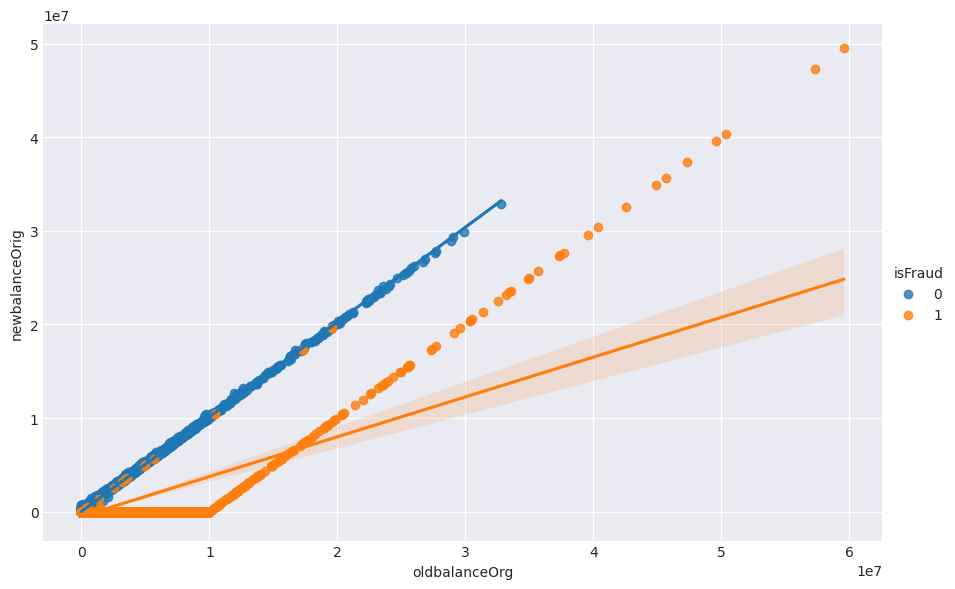

In [48]:
sns.lmplot(data=df_undersampled, x='oldbalanceOrg',y='newbalanceOrig', hue='isFraud', height=6, aspect=1.5)

Because of fraudulent activity we can see that most types of fraud will not reflect on the new balance of the account owner

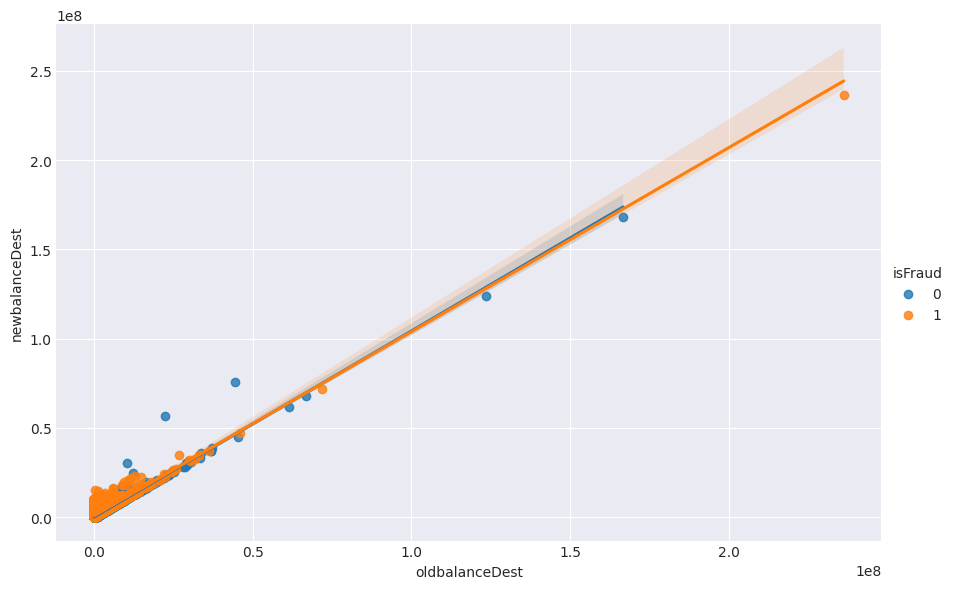

In [49]:
sns.lmplot(data=df_undersampled, x='oldbalanceDest',y='newbalanceDest', hue='isFraud', height=6, aspect=1.5)

Here you can see that fraudulent activity is be reflected on the thiefs old account balance because they stole the money

#### What are the key factors that predict fraudulent customer? 

* Transaction Amount: Fraudulent transactions often involve amounts that are significantly higher or lower than normal to exploit limits or to test the account.
* Transaction Timing (Steps): Unusual transaction times can indicate attempts to avoid detection when monitoring might be reduced.
* Device Information: Fraudsters often use different devices to avoid detection; hence, new or unrecognized devices are suspicious.
* Features such as Transaction Types (Cash, Payment, etc.) as well as Old Account Balance and New Account Balance are key features in predicting fraudulent transactions

# Modeling

Random Forest Classifier is used for training and evaluating the model

In [50]:
def train_eval_rf(X, y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42, test_size = 0.3)
    
    rf = RandomForestClassifier(random_state = 42)
    rf.fit(X_train, y_train)
    y_pred = rf.predict(X_test)
    print('Accuracy Score:')
    print(accuracy_score(y_test, y_pred))
    print("Classification Report:")
    print(classification_report(y_test, y_pred))

In [51]:
train_eval_rf(X_undersampled, y_undersampled)

Accuracy Score:
0.9912743506493507
Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.98      0.99      2479
           1       0.98      1.00      0.99      2449

    accuracy                           0.99      4928
   macro avg       0.99      0.99      0.99      4928
weighted avg       0.99      0.99      0.99      4928



## RESULT
Using Random Forest Classifier, we are able to achieve a very good result, with the accuracy being as high as ~99%

You can also try with the Oversampled data instead of Downsampled one

In [ ]:
# train_eval_rf(X_oversampled, y_oversampled)

#### What kind of prevention should be adopted while company update its infrastructure?

When a company updates its infrastructure, especially in the context of fraud detection, several preventive measures should be adopted to ensure the integrity, security, and effectiveness of the fraud detection systems. Here are some key prevention strategies:

* Robust Security Measures
Encryption: Ensure that all sensitive data is encrypted both in transit and at rest.
Access Control: Implement strong access control policies to restrict access to sensitive systems and data only to authorized personnel.
Authentication: Use multi-factor authentication (MFA) to enhance the security of access to critical systems.
* Regular Audits and Monitoring
Continuous Monitoring: Deploy continuous monitoring tools to track system performance and detect any unusual activities.
Audits: Conduct regular security audits and vulnerability assessments to identify and fix potential security gaps.
* Data Integrity and Backup
Data Integrity: Use checksums and hash functions to ensure data integrity. Any alteration in data should be easily detectable.
Backups: Maintain regular backups of critical data and ensure that these backups are stored securely and can be restored promptly in case of data loss.
* Update Management
Patching: Keep all systems, software, and applications up to date with the latest security patches.
Change Management: Implement a robust change management process to document and review changes before they are applied to the production environment.
* Employee Training and Awareness
Training Programs: Conduct regular training sessions for employees to keep them aware of the latest fraud tactics and security practices.
Phishing Simulations: Run phishing simulations to educate employees on how to recognize and respond to phishing attacks.
* Advanced Fraud Detection Techniques
Machine Learning Models: Update and retrain machine learning models regularly to adapt to new fraud patterns.
Anomaly Detection: Implement advanced anomaly detection techniques to identify suspicious activities that deviate from the norm.
* Redundancy and Failover
Redundant Systems: Design systems with redundancy to ensure continuous operation in case of hardware or software failure.
Failover Mechanisms: Implement failover mechanisms to automatically switch to backup systems in the event of a failure.
* Legal and Compliance
Compliance: Ensure that the infrastructure updates comply with relevant laws, regulations, and industry standards (e.g., GDPR, PCI DSS).
Documentation: Maintain comprehensive documentation of all systems, processes, and changes to facilitate compliance and audits.
* Incident Response Plan
Preparation: Develop and regularly update an incident response plan to address potential fraud incidents.
Response Team: Establish a dedicated response team trained to handle fraud incidents swiftly and effectively.
* Vendor Management
Vendor Assessment: Carefully assess third-party vendors and ensure they adhere to your security standards.
Contracts: Include clauses in contracts with vendors to ensure they comply with security and data protection requirements

### Determining if the preventive actions implemented during an infrastructure update are effective involves a combination of monitoring, testing, and evaluation processes. 

1. Monitoring and Reporting
Continuous Monitoring: Implement continuous monitoring tools to track the performance and security of the infrastructure. Use dashboards to visualize key metrics such as incident rates, system uptime, and transaction volumes.
Real-Time Alerts: Set up real-time alerts for any suspicious activities or anomalies detected by fraud detection systems. Monitor the frequency and accuracy of these alerts.
Incident Reports: Analyze incident reports to understand the types and frequencies of fraud attempts and successful detections. Look for trends or patterns over time.
2. Key Performance Indicators (KPIs)
Detection Rate: Measure the percentage of fraudulent activities successfully detected by the system.
False Positive Rate: Track the rate of legitimate transactions incorrectly flagged as fraudulent.
Response Time: Monitor the time taken to respond to and resolve fraud alerts.
System Uptime: Ensure the infrastructure remains operational and resilient with minimal downtime.
3. Security Audits and Penetration Testing
Regular Audits: Conduct regular security audits to assess the compliance and effectiveness of security measures. These should include reviews of access controls, encryption methods, and incident response processes.
Penetration Testing: Perform penetration testing to identify and address vulnerabilities within the system. This helps to ensure that the security measures in place can withstand potential attacks.
4. User Feedback and Surveys
Employee Feedback: Collect feedback from employees, especially those in fraud detection and response roles, to understand the practicality and effectiveness of the implemented measures.
Customer Feedback: Engage with customers to gather feedback on their experience, particularly if any legitimate transactions were wrongly flagged or if they faced any issues related to fraud prevention measures.
5. Performance Reviews and Benchmarking
Internal Reviews: Conduct periodic performance reviews to evaluate the overall effectiveness of the fraud detection and prevention measures.
Benchmarking: Compare the performance metrics against industry standards and benchmarks to ensure your systems are performing at or above expected levels.
6. Scenario Testing and Simulations
Red Team Exercises: Organize red team exercises where a group simulates attacks on the system to test the robustness of security measures.
Phishing Simulations: Conduct phishing simulations to test employee awareness and response to phishing attempts.
Incident Response Drills: Run incident response drills to ensure the response team is well-prepared and can act quickly in case of a fraud incident.
7. Machine Learning Model Evaluation
Model Validation: Regularly validate and retrain machine learning models using fresh data to ensure they remain effective in detecting new fraud patterns.
Performance Metrics: Evaluate model performance using metrics such as precision, recall, F1 score, and ROC-AUC.
8. Compliance Checks
Regulatory Compliance: Ensure ongoing compliance with relevant laws and regulations (e.g., GDPR, PCI DSS). Conduct compliance audits and reviews to verify adherence.
Documentation Review: Regularly review and update documentation related to security policies, procedures, and incident response plans.